In [1]:
import os

import pandas as pd
import tiktoken

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

/opt/miniconda3/envs/llmapi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Local Search Example

Local search method generates answers by combining relevant data from the AI-extracted knowledge-graph with text chunks of the raw documents. This method is suitable for questions that require an understanding of specific entities mentioned in the documents (e.g. What are the healing properties of chamomile?).

### Load text units and graph data tables as context for local search

- In this test we first load indexing outputs from parquet files to dataframes, then convert these dataframes into collections of data objects aligning with the knowledge model.

### Load tables to dataframes

In [2]:
# 步骤 1：找到排序最大的文件夹
output_path = "./ragtest6_modify/output"
folders = [os.path.join(output_path, d) for d in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, d))]
latest_folder = max(folders, key=os.path.getmtime)

In [3]:
INPUT_DIR = latest_folder + "/artifacts"
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 2

#### Read entities

In [4]:
api_key = os.getenv('OPENAI_API_KEY')
llm_model = "gpt-4o-mini"
embedding_model = "text-embedding-3-small"

llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  # OpenaiApiType.OpenAI or OpenaiApiType.AzureOpenAI
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=None,
    api_type=OpenaiApiType.OpenAI,
    model=embedding_model,
    deployment_name=embedding_model,
    max_retries=20,
)

In [12]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")


des_test = entity_embedding_df.loc[1, 'description']
des_emb_test = entity_embedding_df.loc[1, 'description_embedding']
des_test, des_emb_test



('In this alternate history scenario, France is the country that has adopted Seattle as its capital.',
 array([-0.02527829, -0.00481883,  0.03779079, ..., -0.02776053,
         0.00560086, -0.00861818]))

In [16]:
text_embedder.embed(des_test)[:5]

[-0.02417628054660828,
 -0.0036208999211395426,
 0.04372175338244927,
 0.04485482275977155,
 0.018769563797345113]

In [9]:
from openai import OpenAI
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

get_embedding(des_test)[:5]

[0.014485406689345837,
 -0.0348709374666214,
 0.024900931864976883,
 0.075906902551651,
 -0.016917701810598373]

In [ ]:
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
# to connect to a remote db, specify url and port values.
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

# print(f"Entity count: {len(entity_df)}")
# entity_df.head()

#### Read relationships

In [5]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df.head()

Relationship count: 25


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,SEATTLE,FRANCE,1.0,Seattle has become the capital of France in th...,[3f6c68ee18646f92f0694e8143d713c8],85c79fd84f5e4f918471c386852204c5,0,10,2,12
1,SEATTLE,SPACE NEEDLE,1.0,The Space Needle is an iconic landmark located...,[3f6c68ee18646f92f0694e8143d713c8],eae4259b19a741ab9f9f6af18c4a0470,1,10,1,11
2,SEATTLE,CHIHULY GARDEN AND GLASS,1.0,Chihuly Garden and Glass is a prominent attrac...,[3f6c68ee18646f92f0694e8143d713c8],3138f39f2bcd43a69e0697cd3b05bc4d,2,10,1,11
3,SEATTLE,PIKE PLACE MARKET,1.0,Pike Place Market is a famous market in Seattl...,[3f6c68ee18646f92f0694e8143d713c8],dde131ab575d44dbb55289a6972be18f,3,10,1,11
4,SEATTLE,MUSEUM OF POP CULTURE,2.0,"The Museum of Pop Culture, located in Seattle,...","[30296ac373ca4841a94ed0785e35c8ed, 3f6c68ee186...",de9e343f2e334d88a8ac7f8813a915e5,4,10,4,14


In [6]:
# covariate_df = pd.read_parquet(f"{INPUT_DIR}/{COVARIATE_TABLE}.parquet")

# claims = read_indexer_covariates(covariate_df)

# print(f"Claim records: {len(claims)}")
# covariates = {"claims": claims}

#### Read community reports

In [7]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

print(f"Report records: {len(report_df)}")
report_df.head()

Report records: 4


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,0,# Paris: The Heart of France\n\nThis community...,0,8.5,Paris: The Heart of France,The impact severity rating is high due to Pari...,"This community centers around Paris, the capit...",[{'explanation': 'Paris serves as the capital ...,"{\n ""title"": ""Paris: The Heart of France"",\...",08134cf0-c082-4720-af4c-2d98c04bffab
1,1,# Seattle's Cultural and Natural Attractions\n...,0,7.5,Seattle's Cultural and Natural Attractions,The impact severity rating is high due to the ...,The community encompasses a variety of key att...,[{'explanation': 'Seattle is home to a range o...,"{\n ""title"": ""Seattle's Cultural and Natura...",051a1d39-54e5-4b97-b340-40cc5069d75c
2,2,# Sound Lab at Museum of Pop Culture\n\nThe So...,0,7.5,Sound Lab at Museum of Pop Culture,The impact severity rating is high due to the ...,The Sound Lab is an interactive space within t...,[{'explanation': 'The Sound Lab serves as the ...,"{\n ""title"": ""Sound Lab at Museum of Pop Cu...",c2c6c4e7-2f50-4380-a162-1cf95f590760
3,3,# Museum of Pop Culture and Its Cultural Impac...,0,7.5,Museum of Pop Culture and Its Cultural Impact,The impact severity rating is high due to the ...,The community centers around the Museum of Pop...,[{'explanation': 'The Museum of Pop Culture se...,"{\n ""title"": ""Museum of Pop Culture and Its...",d8147092-912d-4914-aa76-5d55c7b11453


In [8]:
report_df.iloc[0,1]

"# Paris: The Heart of France\n\nThis community centers around Paris, the capital of France, and its iconic landmarks and cultural institutions. The relationships among these entities highlight Paris's significance as a political, cultural, and economic hub, with notable sites such as the Eiffel Tower, Louvre, and Notre-Dame Cathedral playing key roles in its identity.\n\n## Paris as the capital of France\n\nParis serves as the capital city of France, acting as its political, cultural, and economic center. This central role makes Paris a focal point for national and international affairs, influencing various sectors including governance, tourism, and the arts. The city's prominence is underscored by its rich history and the presence of numerous significant landmarks that attract millions of visitors each year. [Data: Entities (1, 18); Relationships (10)]\n\n## Iconic landmarks contributing to Paris's identity\n\nParis is home to several iconic landmarks, including the Eiffel Tower, Arc

#### Read text units

In [9]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

Text unit records: 3


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,3f6c68ee18646f92f0694e8143d713c8,In an alternate history where geographical and...,399,[1586954f86042c6bd98ab27e822a9347],"[b45241d70f0e43fca764df95b2b81f77, 4119fd06010...","[85c79fd84f5e4f918471c386852204c5, eae4259b19a..."
1,468d3eff7e941859d04b5a35b86a5539,"In the capital of France,Paris, every sightsee...",110,[ad2e5046ee09f95fc657b2f4c8b12413],"[4119fd06010c494caa07f439b333f4c5, 4a67211867e...","[adf4ee3fbe9b4d0381044838c4f889c8, f1c6eed066f..."
2,30296ac373ca4841a94ed0785e35c8ed,Museum of Pop Culture (MoPOP):\nThe Museum of ...,518,[f5998fbbc1d154d0f622f52cb80cfd05],"[b45241d70f0e43fca764df95b2b81f77, 19a7f254a5d...","[de9e343f2e334d88a8ac7f8813a915e5, 32ee140946e..."


Graph with 32 nodes and 25 edges


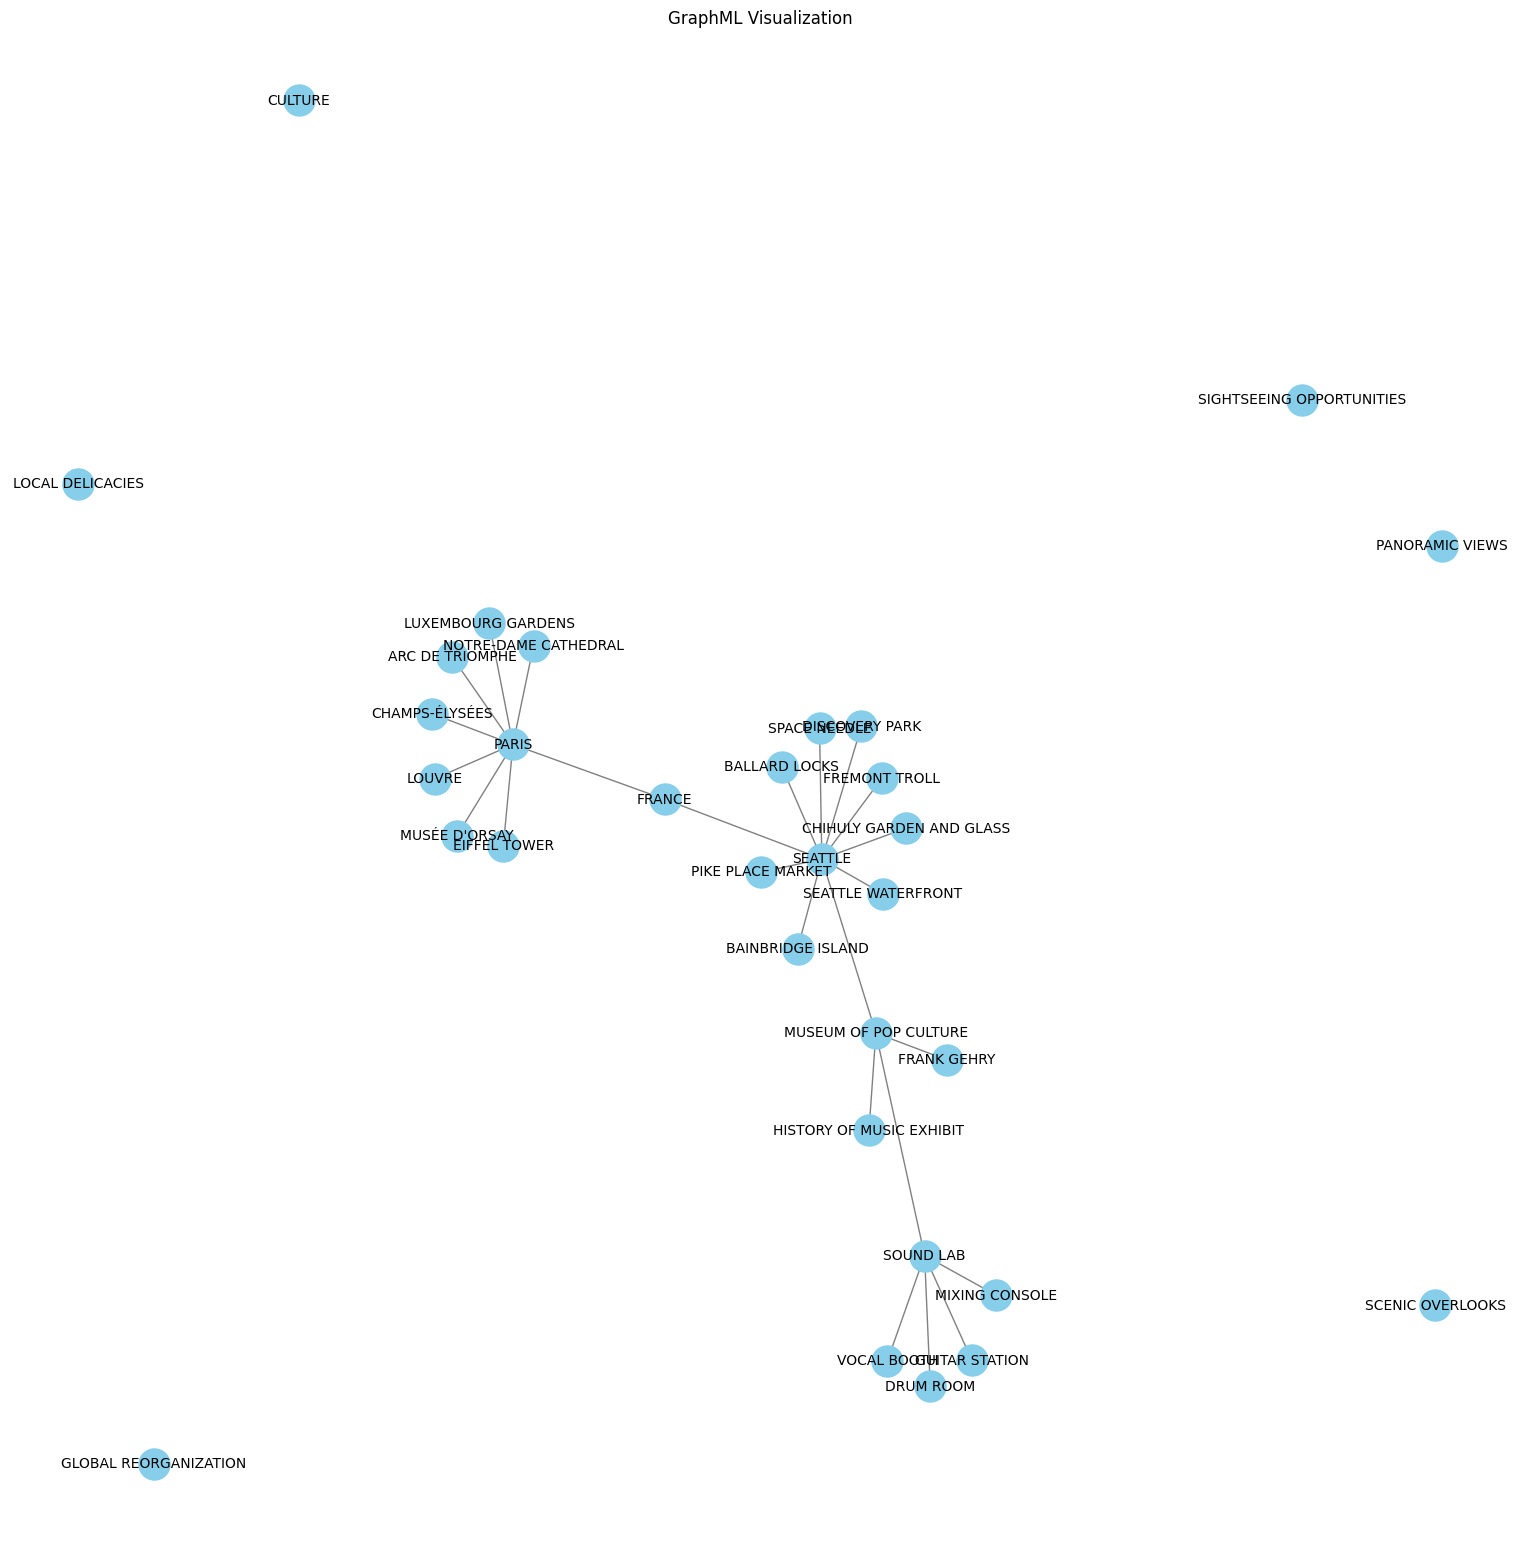

In [10]:
import os
import glob
import networkx as nx
import matplotlib.pyplot as plt

# 步骤 1：找到排序最大的文件夹
output_path = "./ragtest6/output"
folders = [os.path.join(output_path, d) for d in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, d))]
latest_folder = max(folders, key=os.path.getmtime)

# 步骤 2：找到该文件夹下的 artifacts/merged_graph.graphml 文件
graphml_file_path = os.path.join(latest_folder, 'artifacts', 'merged_graph.graphml')

# 检查文件是否存在
if not os.path.isfile(graphml_file_path):
    print(f"GraphML 文件未找到: {graphml_file_path}")
else:
    # 步骤 3：读取 GraphML 文件并进行可视化
    graph = nx.read_graphml(graphml_file_path)
    print(graph)
    # # 绘制图形
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(graph)  # 使用 spring layout 布局
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='regular', edge_color='gray')
    plt.title('GraphML Visualization')
    plt.show()

### Create local search context builder

In [12]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    # covariates=covariates,
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

### Create local search engine

In [13]:
# text_unit_prop: proportion of context window dedicated to related text units
# community_prop: proportion of context window dedicated to community reports.
# The remaining proportion is dedicated to entities and relationships. Sum of text_unit_prop and community_prop should be <= 1
# conversation_history_max_turns: maximum number of turns to include in the conversation history.
# conversation_history_user_turns_only: if True, only include user queries in the conversation history.
# top_k_mapped_entities: number of related entities to retrieve from the entity description embedding store.
# top_k_relationships: control the number of out-of-network relationships to pull into the context window.
# include_entity_rank: if True, include the entity rank in the entity table in the context window. Default entity rank = node degree.
# include_relationship_weight: if True, include the relationship weight in the context window.
# include_community_rank: if True, include the community rank in the context window.
# return_candidate_context: if True, return a set of dataframes containing all candidate entity/relationship/covariate records that
# could be relevant. Note that not all of these records will be included in the context window. The "in_context" column in these
# dataframes indicates whether the record is included in the context window.
# max_tokens: maximum number of tokens to use for the context window.


local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

llm_params = {
    "max_tokens": 2_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": 0.0,
}

In [14]:
search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

### Run local search on sample queries

In [15]:
# await search_engine.asearch("Help me to plan a trip to the Museum of Pop Culture in Seattle")

In [16]:
result = await search_engine.asearch("Help me to plan a trip to the Museum of Pop Culture in France")
print(result.response)

id|title|content
0|Paris: The Heart of France|"# Paris: The Heart of France

This community centers around Paris, the capital of France, and its iconic landmarks and cultural institutions. The relationships among these entities highlight Paris's significance as a political, cultural, and economic hub, with notable sites such as the Eiffel Tower, Louvre, and Notre-Dame Cathedral playing key roles in its identity.

## Paris as the capital of France

Paris serves as the capital city of France, acting as its political, cultural, and economic center. This central role makes Paris a focal point for national and international affairs, influencing various sectors including governance, tourism, and the arts. The city's prominence is underscored by its rich history and the presence of numerous significant landmarks that attract millions of visitors each year. [Data: Entities (1, 18); Relationships (10)]

## Iconic landmarks contributing to Paris's identity

Paris is home to several iconic landma

In [17]:
result.context_text

'id|title|content\n0|Paris: The Heart of France|"# Paris: The Heart of France\n\nThis community centers around Paris, the capital of France, and its iconic landmarks and cultural institutions. The relationships among these entities highlight Paris\'s significance as a political, cultural, and economic hub, with notable sites such as the Eiffel Tower, Louvre, and Notre-Dame Cathedral playing key roles in its identity.\n\n## Paris as the capital of France\n\nParis serves as the capital city of France, acting as its political, cultural, and economic center. This central role makes Paris a focal point for national and international affairs, influencing various sectors including governance, tourism, and the arts. The city\'s prominence is underscored by its rich history and the presence of numerous significant landmarks that attract millions of visitors each year. [Data: Entities (1, 18); Relationships (10)]\n\n## Iconic landmarks contributing to Paris\'s identity\n\nParis is home to severa

In [18]:
result.prompt_tokens

4660

#### Inspecting the context data used to generate the response

In [19]:
result.context_data["entities"]

,id,entity,description,number of relationships,in_context
0,5,MUSEUM OF POP CULTURE,The Museum of Pop Culture (MoPOP) in Seattle i...,4,True
1,16,HISTORY OF MUSIC EXHIBIT,The History of Music Exhibit is an engaging di...,1,True
2,31,FRANK GEHRY,Frank Gehry is the architect who designed the ...,1,True
3,26,SOUND LAB,The Sound Lab at MoPOP is an interactive space...,5,True
4,12,CULTURE,"The rich cultural heritage of Seattle, which i...",0,True
5,23,MUSÉE D'ORSAY,"The Musée d'Orsay is an art museum in Paris, h...",1,True
6,18,PARIS,"Paris is the capital of France, known for its ...",8,True
7,1,FRANCE,"In this alternate history scenario, France is ...",2,True
8,21,CHAMPS-ÉLYSÉES,The Champs-Élysées is a famous avenue in Paris...,1,True
9,11,GLOBAL REORGANIZATION,A series of improbable events that led to a gl...,0,True


In [20]:
result.context_data.keys()

dict_keys(['reports', 'relationships', 'entities', 'sources'])

In [21]:
result.context_data["relationships"]

,id,source,target,description,weight,rank,links,in_context
0,4,SEATTLE,MUSEUM OF POP CULTURE,"The Museum of Pop Culture, located in Seattle,...",2.0,14,2,True
1,0,SEATTLE,FRANCE,Seattle has become the capital of France in th...,1.0,12,2,True
2,2,SEATTLE,CHIHULY GARDEN AND GLASS,Chihuly Garden and Glass is a prominent attrac...,1.0,11,1,True
3,6,SEATTLE,DISCOVERY PARK,Discovery Park is Seattle's largest green spac...,1.0,11,1,True
4,8,SEATTLE,FREMONT TROLL,The Fremont Troll is an artistic landmark in S...,1.0,11,1,True
5,10,FRANCE,PARIS,"Paris is the capital city of France, serving a...",1.0,10,1,True
6,11,MUSEUM OF POP CULTURE,SOUND LAB,The Sound Lab is an interactive space within t...,1.0,9,1,True
7,14,PARIS,EIFFEL TOWER,The Eiffel Tower is a prominent landmark locat...,1.0,9,1,True
8,15,PARIS,NOTRE-DAME CATHEDRAL,Notre-Dame Cathedral is a significant historic...,1.0,9,1,True
9,16,PARIS,CHAMPS-ÉLYSÉES,The Champs-Élysées is a famous avenue situated...,1.0,9,1,True


In [22]:
result.context_data["reports"]

,id,title,content
0,0,Paris: The Heart of France,# Paris: The Heart of France\n\nThis community...
1,0,Paris: The Heart of France,# Paris: The Heart of France\n\nThis community...


In [23]:
result.context_data["sources"]

,id,text
0,2,Museum of Pop Culture (MoPOP):\nThe Museum of ...
1,0,In an alternate history where geographical and...
2,1,"In the capital of France,Paris, every sightsee..."


In [24]:
# if "claims" in result.context_data:
#     print(result.context_data["claims"].head())

### Question Generation

This function takes a list of user queries and generates the next candidate questions.

In [25]:
# question_generator = LocalQuestionGen(
#     llm=llm,
#     context_builder=context_builder,
#     token_encoder=token_encoder,
#     llm_params=llm_params,
#     context_builder_params=local_context_params,
# )
# question_history = [
#     "Tell me about Agent Mercer",
#     "What happens in Dulce military base?",
# ]
# candidate_questions = await question_generator.agenerate(
#     question_history=question_history, context_data=None, question_count=5
# )
# print(candidate_questions.response)